In [1]:
from boututils.datafile import DataFile
from boutdata.collect import collect
from boutdata.data import BoutData
import os, sys
import matplotlib
# matplotlib.use('Qt5Agg',force=True)
# matplotlib.use("TKAgg",force=True)
# matplotlib.use("widget",force=True)
import matplotlib.pyplot as plt
import xbout
import pandas as pd
import numpy as np
import pickle as pkl
import xarray as xr
import netCDF4 as nc

from boutdata.restart import addvar
import glob
import shutil

sys.path.append(r"/ssd_scratch/scripts/sdtools")


from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *
from hermes3.utils import *
from hermes3.neutral_transport import *
# from code_comparison.code_comparison import *


%load_ext autoreload
%autoreload 2

/ssd_scratch/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
casestore = dict()

In [3]:
db = CaseDB(
    case_dir = r"/ssd_scratch/hcases",
    grid_dir = r"/ssd_scratch/hcases"
    )

toload = [
    dict(name="base", id="xcol1ab-newfluxlim-tests", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),
    # dict(name="base", id="xcol1a-base-tests", grid="g3b1-lores_newhypno.nc", unnormalise_geom = True),

]


for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                            double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                            unnormalise_geom = case["unnormalise_geom"])


CHECK: Total domain volume is 1.607E+00 [m3]


In [4]:
ds = casestore["base"].ds
ds = calculate_radial_fluxes(ds)

In [5]:
domain = ds
m = ds.metadata
Te = domain["Te"].values
Ta = domain["Td"].values
Ti = domain["Td+"].values
Ne = domain["Ne"].values
Na = domain["Nd"].values
Pa = domain["Pd"].values
Dn = domain["Dnnd"].values
Fa = domain["NVd"].values
Fi = domain["NVd+"].values
dx = domain["dx"].values
dy = domain["dy"].values
dz = domain["dz"].values
dl = ds["dl"].values
dr = ds["dr"].values
J = ds["J"].values
g11 = ds["g11"].values
q_e = constants("q_e")
mp = constants("mass_p")
me = constants("mass_e")

neut = NeutralTransport(domain, inputs = dict(
                                                Te = Te,
                                                Ta = Ta,
                                                Ti = Ti,
                                                Ne = Ne,
                                                Na = Na,
                                                Pa = Pa,
                                                dy = dy,
                                                dz = dz,
                                                dl = dl, 
                                                dr = dr,
                                                J = J,
                                                g11 = g11,
                                                dx = dx
                                                ))
neut.get_rates(reproduce_bug = True)
neut.get_Dn(collisions = ["cx", "nn", "ne", "ni", "nnlim"],
            flux_limiter = "none",
            alpha = 0.2)

ds["Dn_calc"] = (["x", "theta"], neut.Dn)
ds["Dn_calc"].attrs["metadata"] = ds.metadata

2D data detected


# Flux limiter factors

In [6]:
ds["dr"].attrs

{'conversion': 1,
 'units': 'm',
 'standard_name': 'radial length',
 'long_name': 'Length of cell in the radial direction',
 'source': 'xHermes'}

Text(0.5, 1.0, 'Flux limiter factor')

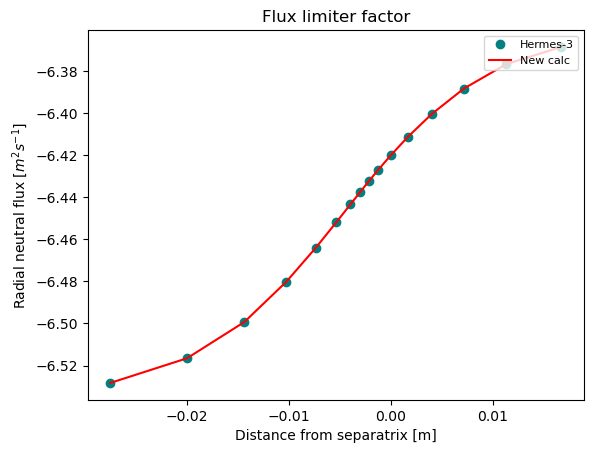

In [8]:
fig, ax = plt.subplots()

omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = omp["R"] - omp["R"].isel(x = omp.metadata["ixseps1"])

# Dn = omp["Dn_calc"]
# Vn = omp["NVd"] / (omp["Nd"] * mp*2)
# Pa = omp["Pd"]
# Na = omp["Nd"]
# Ta = omp["Td"]
# J = omp["J"]
# g_12 = omp["g_12"] * (1/m["Bnorm"])
# alpha = 1
# gamma = 2
# v_perp = omp["Dn_calc"] * np.log(omp["Pd"]).bout.ddx()

# ----- Normalised inputs
Pa = ds["Pd"].values / (m["Nnorm"] * m["Tnorm"] * q_e)
dr = ds["dr"].values / m["rho_s0"]

# ----- xBOUT operator
# lnP = np.log(ds["Pd"])
# grad_lnP_perp_x = lnP.bout.ddx() #- (ds["g_12"]/m["Bnorm"]) * lnP.bout.ddy() / np.sqrt(ds["J"] * ds["Bxy"])
# grad_lnP_perp_x *= ds["g11"]  # Because ddx returns covariant
# ds["grad_lnP_perp_x"] = (["x", "theta"], grad_lnP_perp_x.values)

# ----- Explicit operator

f = np.log(Pa)
nx = f.shape[0]
ny = f.shape[1]
dfdx = np.zeros_like(f)
dfdy = np.zeros_like(f)

for i in range(nx):
    for j in range(ny):
        if i > 0 and i < nx-1 and j > 0 and j < ny-1:
            dfdx[i,j] = (f[i+1,j] - f[i-1,j]) / (2*dr[i,j])
            # dfdy[i,j] = (f[i,j+1] - f[i,j-1]) / (2*dl[i,j])
ds["grad_lnP_perp_x"] = (["x", "theta"], dfdx)

ds["grad_lnP_perp_x"] = (["x", "theta"], f)

omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
# v_perp = omp["Dn_calc"] * np.gradient(np.log(omp["Pd"]), dist)


# v_abs = np.sqrt(v_perp**2 + Vn**2)
# flux_abs = Na * v_abs
# particle_limit = Na * 0.25 * np.sqrt(8 * q_e*Ta / (np.pi*2*mp))
# particle_flux_factor = ( (flux_abs/(alpha * particle_limit))**gamma )**(-1/gamma)
# particle_flux_factor = v_perp

# ax.plot(dist, -omp["particle_flux_factor_d"] * m["rho_s0"]*m["Omega_ci"], label = "Hermes-3", marker = "o", c = "teal", lw = 0)
ax.plot(dist, omp["particle_flux_factor_d"] , label = "Hermes-3", marker = "o", c = "teal", lw = 0)
ax.plot(dist, omp["grad_lnP_perp_x"], label = "New calc", c = "red")

ax.legend(fontsize=8, loc = "upper right")
# ax.set_ymargin(0.1)
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Radial neutral flux $[m^{2}s^{-1}]$")
# ax.set_yscale("log")
ax.set_title("Flux limiter factor")

In [ ]:
ds["grad_lnP_perp_x"].bout.polygon()

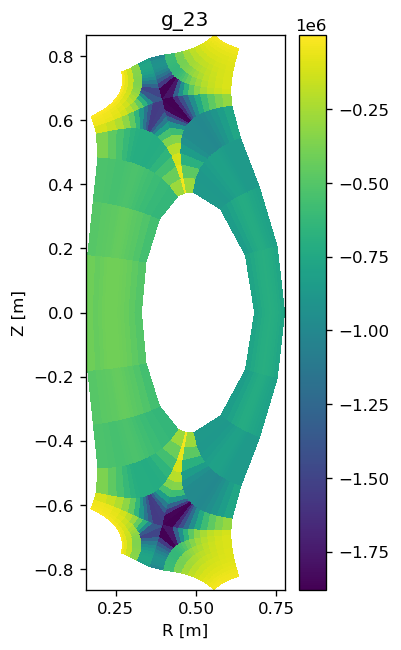

In [9]:
ds["g_23"].bout.polygon()

In [42]:
ds["Pe"].bout.ddz().bout.polygon()

ValueError: dimensions ['zeta'] do not exist

2D data detected


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'Collision frequency ${\\alpha}$ $[s^{-1}]$')

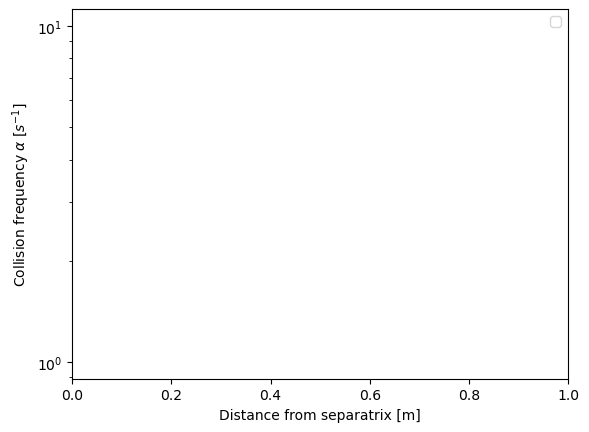

In [6]:
# domain = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
domain = ds
m = ds.metadata
Te = domain["Te"].values
Ta = domain["Td"].values
Ti = domain["Td+"].values
Ne = domain["Ne"].values
Na = domain["Nd"].values
Pa = domain["Pd"].values
Dn = domain["Dnnd"].values
Fa = domain["NVd"].values
Fi = domain["NVd+"].values
dx = domain["dx"].values
dy = domain["dy"].values
dz = domain["dz"].values
dl = ds["dl"].values
dr = ds["dr"].values
J = ds["J"].values
g11 = ds["g11"].values
q_e = constants("q_e")
mp = constants("mass_p")
me = constants("mass_e")

neut = NeutralTransport(domain, inputs = dict(
                                                Te = Te,
                                                Ta = Ta,
                                                Ti = Ti,
                                                Ne = Ne,
                                                Na = Na,
                                                Pa = Pa,
                                                dy = dy,
                                                dz = dz,
                                                dl = dl, 
                                                dr = dr,
                                                J = J,
                                                g11 = g11,
                                                dx = dx
                                                ))
neut.get_rates(reproduce_bug = True)
rates = neut.k

# Put rate back into dataset
for rate in rates:
    ds[rate] = (["x", "theta"], rates[rate])
    ds[rate].attrs["metadata"] = ds.metadata

omp = domain
omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = omp["R"] - omp["R"].isel(x = omp.metadata["ixseps1"])

fig, ax = plt.subplots()

# ax.plot(dist, omp["cx"], label = "CX")
# ax.plot(dist, omp["nn"], label = "NN", c = "darkorange")
# ax.plot(dist, omp["Kdd_coll"]* m["Omega_ci"], marker = "o", lw = 0, c = "darkorange")
# ax.plot(dist, omp["nnlim"], label = "NNlim", c = "teal")
# ax.plot(dist, omp["ne"], label = "NE", c = "firebrick")
# ax.plot(dist, omp["Kde_coll"]* m["Omega_ci"], marker = "o", lw = 0, c = "firebrick")
# ax.plot(dist, omp["ni"], label = "NI", c = "limegreen")
# ax.plot(dist, omp["Kdd+_coll"]* m["Omega_ci"], marker = "o", lw = 0, c = "limegreen")

ax.legend()
ax.set_yscale("log")
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Collision frequency ${\\alpha}$ $[s^{-1}]$")

Text(0, 0.5, 'Neutral diffusion coefficient [$m^2$/s]')

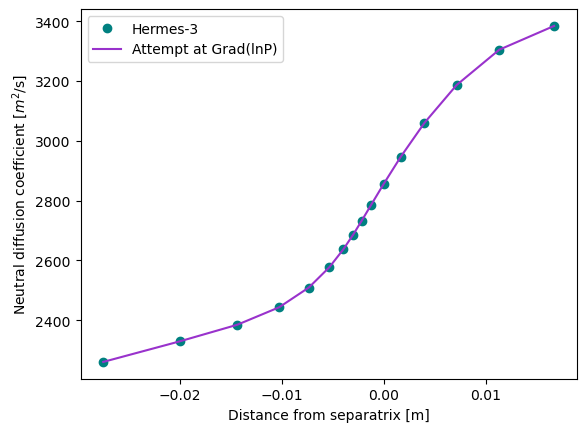

In [8]:
neut.get_Dn(collisions = ["cx", "nn", "ne", "ni", "nnlim"],
            flux_limiter = "none",
            alpha = 0.2)

ds["Dn_calc"] = (["x", "theta"], neut.Dn)
ds["Dn_calc"].attrs["metadata"] = ds.metadata


omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = omp["R"] - omp["R"].isel(x = omp.metadata["ixseps1"])

fig, ax = plt.subplots()
ax.plot(dist, omp["Dnnd"], label = "Hermes-3", marker = "o", c = "teal", lw = 0)
ax.plot(dist, omp["Dn_calc"], label = "Attempt at Grad(lnP)", c = "darkorchid")

ax.legend()
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Neutral diffusion coefficient [$m^2$/s]")
# ax.set_yscale("log")

# Flux

Text(0.5, 1.0, 'Face center flux comparison')

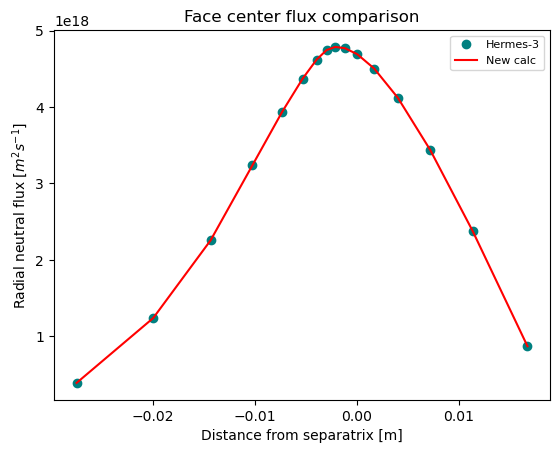

In [9]:
fig, ax = plt.subplots()


omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = omp["R"] - omp["R"].isel(x = omp.metadata["ixseps1"])
da = omp["dy"] * omp["dz"] 

flux_ref = (omp["pf_perp_diff_R_d"] + omp["pf_perp_diff_L_d"])/2 
    
neut.get_flux()
ds["flux_calc"] = (["x", "theta"], neut.flux)
ds["flux_calc"].attrs["metadata"] = ds.metadata
omp = ds.hermesm.select_region("outer_midplane_a").isel(x=slice(2,-2))
dist = omp["R"] - omp["R"].isel(x = omp.metadata["ixseps1"])


ax.plot(dist, -flux_ref, label = "Hermes-3", marker = "o", c = "teal", lw = 0)
ax.plot(dist, -omp["flux_calc"], label = "New calc", c = "red")

ax.legend(fontsize=8, loc = "upper right")
# ax.set_ymargin(0.1)
ax.set_xlabel("Distance from separatrix [m]")
ax.set_ylabel("Radial neutral flux $[m^{2}s^{-1}]$")
# ax.set_yscale("log")
ax.set_title("Face center flux comparison")

In [15]:
np.sqrt(1/4)

0.5

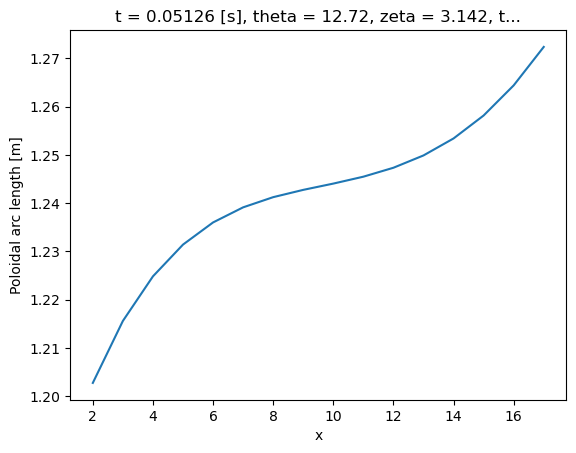

In [22]:
(omp["dl"]*omp["dz"]).plot()

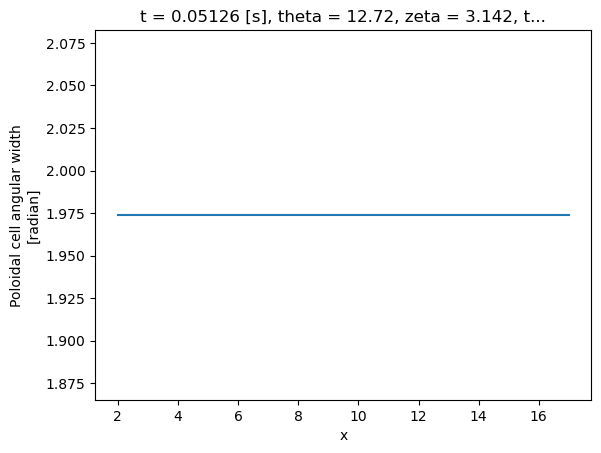

In [20]:
(omp["dy"] * omp["dz"]).plot()

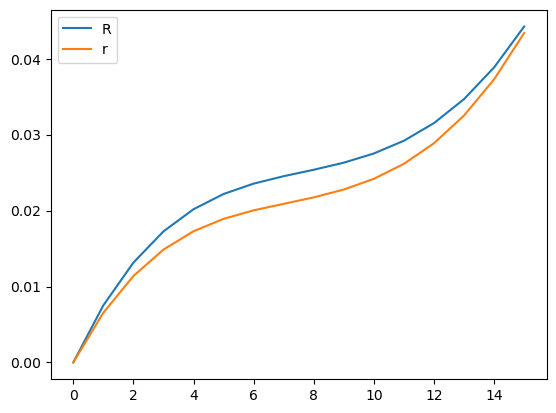

In [ ]:
R = omp["R"] - omp["R"][0]
dR = R.diff("x")

dr = omp["dx"] / np.sqrt(omp["g11"]) #(omp["R"]*omp["Bpxy"])
r = np.cumsum(dr)
r -= r[0]

fig, ax = plt.subplots()

# ax.plot(dR, label = "dR")
# ax.plot(dr, label = "dr")

ax.plot(R, label = "R")
ax.plot(r, label = "r")
ax.legend()

# NN

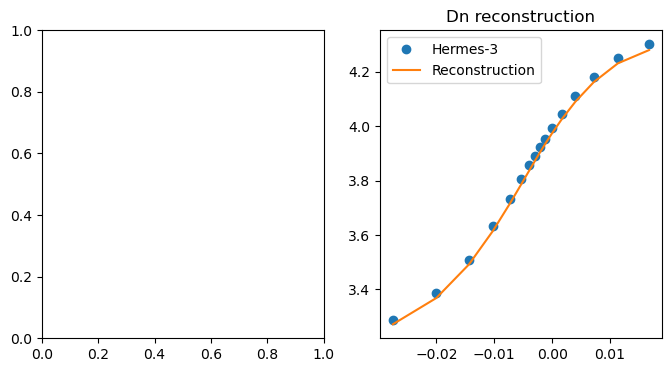

In [9]:
scale = 1
fig, axes = plt.subplots(1,2, figsize=(8*scale,4*scale))


a0 = np.pi * (2.8e-10)**2   # AKA 2.5e-19
vrel = np.sqrt(2 * q_e * (Ta/(mp*2) + Ta/(mp*2)))
nu_nn = vrel * Na *  a0 /2

K_reconstruction = nu_nn

ax = axes[1]
ax.plot(dist, domain["Kdd_coll"]*m["Omega_ci"], label = "Hermes-3", marker = "o", lw = 0)
ax.plot(dist, K_reconstruction*1.0, label = "Reconstruction")
ax.set_title("Dn reconstruction")

ax.legend()

# NI

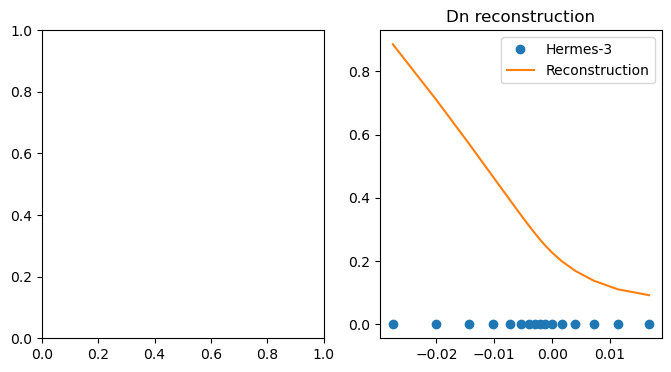

In [6]:
scale = 1
fig, axes = plt.subplots(1,2, figsize=(8*scale,4*scale))

# NI ----------------
# a0 = 5e-19
# vrel = np.sqrt((q_e * Ta / (mp*2)) + (q_e * Ti / (mp*2)) )
# nu_ni = vrel * Ne * a0

a0 = 5e-19
# vrel = np.sqrt( (Ta / (m["Tnorm"] * 2)) + (Ti / (m["Tnorm"]*2)) )
vrel = Ti/ m["Tnorm"]

# nu_ni = vrel * Ne * a0 * m["rho_s0"]

K_reconstruction = vrel

ax = axes[1]
ax.plot(dist, domain["Kdd+_coll"], label = "Hermes-3", marker = "o", lw = 0)
ax.plot(dist, K_reconstruction*1.0, label = "Reconstruction")
ax.set_title("Dn reconstruction")

ax.legend()

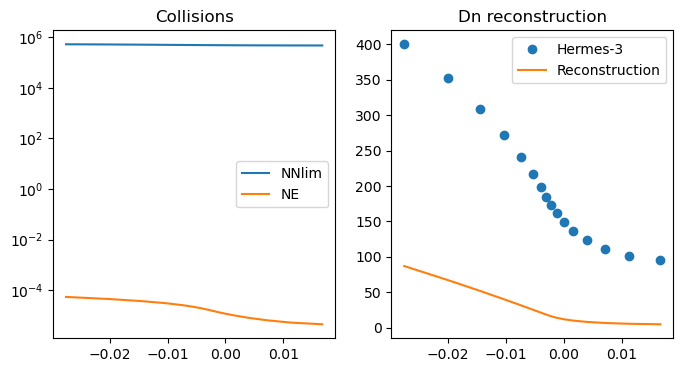

In [6]:
scale = 1
fig, axes = plt.subplots(1,2, figsize=(8*scale,4*scale))

vth_n = np.sqrt(constants("q_e")*Ta / (constants("mass_p")*2))

# RNN ----------------   
Rnn = vth_n / 0.1   # Forced to 0.1m no matter what

# EN ----------------
# a0 = 5e-19
# vth_e = np.sqrt( (Te*constants("q_e") / (constants("mass_e"))))     # In Hermes-3 Me is normalised by Mp
# nu_en = vth_e * Na * a0
# nu_ne = nu_en * constants("mass_e")/(constants("mass_p")*2) * Ne/ Na 

a0 = 5e-19
T = Te / m["Tnorm"]
N = Na / m["Nnorm"]
vth_e = np.sqrt( (mp/me) * T)     # In Hermes-3 Me is normalised by Mp
nu_en = vth_e * m["Nnorm"] * N * a0 * m["rho_s0"]
nu_ne = nu_en * constants("mass_e")/(constants("mass_p")*2) * Ne/ Na 

K_reconstruction = Te

ax = axes[1]
ax.plot(dist, domain["Ked_coll"], label = "Hermes-3", marker = "o", lw = 0)
ax.plot(dist, K_reconstruction*1, label = "Reconstruction")
ax.set_title("Dn reconstruction")

ax = axes[0]
ax.plot(dist, Rnn, label = "NNlim")
ax.plot(dist, nu_ne, label = "NE")
ax.set_title("Collisions")
for ax in axes:
    ax.legend()
axes[0].set_yscale("log")

In [18]:
path = r"/ssd_scratch/hcases/colldev/xcol1a-base-tests"


In [20]:
for i in range(9):
    path_dmp = os.path.join(path, f"BOUT.dmp.{i}.nc")
    d = nc.Dataset(path_dmp)
    print(d["MYPE"][:].data)
    if 'Kd+d+_coll' in d.variables:
        print(f"Found Kd+d+_coll in {path_dmp}")
    
    d.close()
    

0
Found Kd+d+_coll in /ssd_scratch/hcases/colldev/xcol1a-base-tests/BOUT.dmp.0.nc
1
2
3
Found Kd+d+_coll in /ssd_scratch/hcases/colldev/xcol1a-base-tests/BOUT.dmp.3.nc
4
Found Kd+d+_coll in /ssd_scratch/hcases/colldev/xcol1a-base-tests/BOUT.dmp.4.nc
5
6
7
8
Found Kd+d+_coll in /ssd_scratch/hcases/colldev/xcol1a-base-tests/BOUT.dmp.8.nc


In [11]:
d.close()

In [16]:
d["PE_XIND"][:].data

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [12]:
d = nc.Dataset(r"/ssd_scratch/hcases/colldev/xcol1a-base-tests/BOUT.dmp.1.nc")
[print(x) for x in d.variables.keys()]
# PE_XIND
# PE_YIND
R = casestore["base"].ds["R"].values
Z = casestore["base"].ds["Z"].values
x = d["PE_XIND"][:]
y = d["PE_YIND"][:]

fig, ax = plt.subplots(dpi = 130)
ax.scatter(R, Z, c = "k", s = 1)
ax.set_aspect("equal")
# d.close()

BOUT_VERSION
Bnorm
Bxy
Cs0
Dnnd
Ed+_iz
Ed+_rec
Edd+_cx
EnergyFlow_d+_xlow
EnergyFlow_d+_ylow
EnergyFlow_e_xlow
EnergyFlow_e_ylow
Fd+_iz
Fd+_rec
Fdd+_cx
G1
G2
G3
HERMES_REVISION
J
MXG
MXSUB
MYG
MYPE
MYSUB
MZ
MZG
MZSUB
MomentumFlow_d+_xlow
NVd
NVd+
NXPE
NYPE
NZPE
Nd
Nd+
Ne
Nnorm
Omega_ci
PE_XIND
PE_YIND
ParticleFlow_d+_xlow
ParticleFlow_d+_ylow
Pd
Pd+
Pd+_src
Pd_src
Pe
Pe_src
Rd+_ex
Rd+_rec
SNVd
SNVd+
SNd
SNd+
SPd
SPd+
SPe
Sd+_iz
Sd+_rec
Sd+_src
Sd_src
Td
Td+
Te
Tnorm
Vd+
Ve
ZMAX
ZMIN
anomalous_Chi_d+
anomalous_Chi_e
anomalous_D_d+
anomalous_D_e
anomalous_nu_d+
anomalous_nu_e
cvode_last_order
cvode_last_step
cvode_nfevals
cvode_nliters
cvode_nniters
cvode_nonlin_fails
cvode_npevals
cvode_nsteps
cvode_num_fails
cvode_stab_lims
ddt(NVd)
ddt(NVd+)
ddt(Nd)
ddt(Nd+)
ddt(Pd)
ddt(Pd+)
ddt(Pe)
dx
dy
dz
g11
g12
g13
g22
g23
g33
g_11
g_12
g_13
g_22
g_23
g_33
has_fftw
has_gettext
has_lapack
has_netcdf
has_petsc
has_pretty_function
has_pvode
has_scorep
has_slepc
has_sundials
hist_hi
iteration
ixseps1

KeyError: 'base'

In [11]:
x

masked_array(data=0,
             mask=False,
       fill_value=999999,
            dtype=int32)

In [5]:
ds = casestore["base"].ds
ds["Kdd+_coll"].values

array(['d+ = <Field3D>', 'd+ = <Field3D>'], dtype=object)

In [4]:
ds = casestore["base"].ds

ds.data_vars

Data variables:
    Bxy                   (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Dnnd                  (t, x, theta) float64 dask.array<chunksize=(2, 20, 7), meta=np.ndarray>
    Ed+_iz                (t, x, theta) float64 dask.array<chunksize=(2, 20, 7), meta=np.ndarray>
    Ed+_rec               (t, x, theta) float64 dask.array<chunksize=(2, 20, 7), meta=np.ndarray>
    Edd+_cx               (t, x, theta) float64 dask.array<chunksize=(2, 20, 7), meta=np.ndarray>
    EnergyFlow_d+_xlow    (t, x, theta) float64 dask.array<chunksize=(2, 20, 7), meta=np.ndarray>
    EnergyFlow_d+_ylow    (t, x, theta) float64 dask.array<chunksize=(2, 20, 7), meta=np.ndarray>
    EnergyFlow_e_xlow     (t, x, theta) float64 dask.array<chunksize=(2, 20, 7), meta=np.ndarray>
    EnergyFlow_e_ylow     (t, x, theta) float64 dask.array<chunksize=(2, 20, 7), meta=np.ndarray>
    Fd+_iz                (t, x, theta) float64 dask.array<chunksize=(2, 20, 7), meta=np.ndarray>
    Fd+_re

# Convergence

base


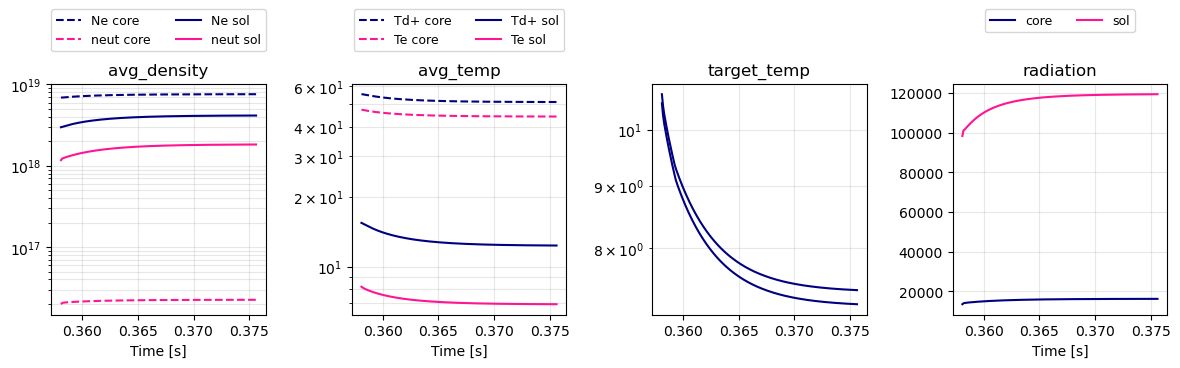

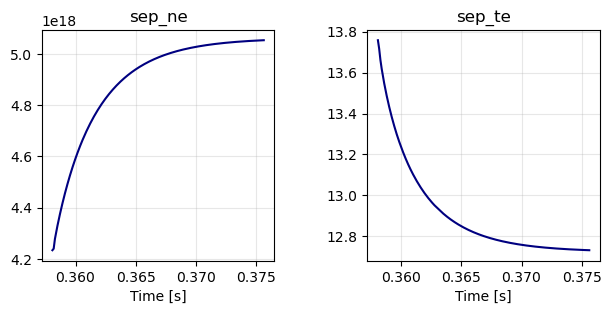

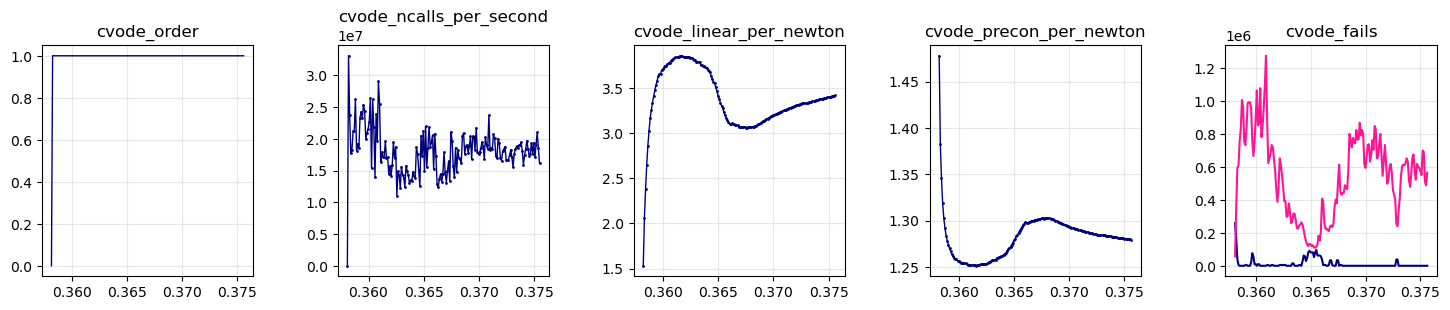

In [4]:
for casename in casestore.keys():
    print(casename)
    Monitor(casestore[casename], [["avg_density", "avg_temp", "target_temp","radiation"],
                                  ["sep_ne", "sep_te"],
                                  ["cvode_order", "cvode_ncalls_per_second", "cvode_linear_per_newton", "cvode_precon_per_newton", "cvode_fails"]
                ])

## Lineplots

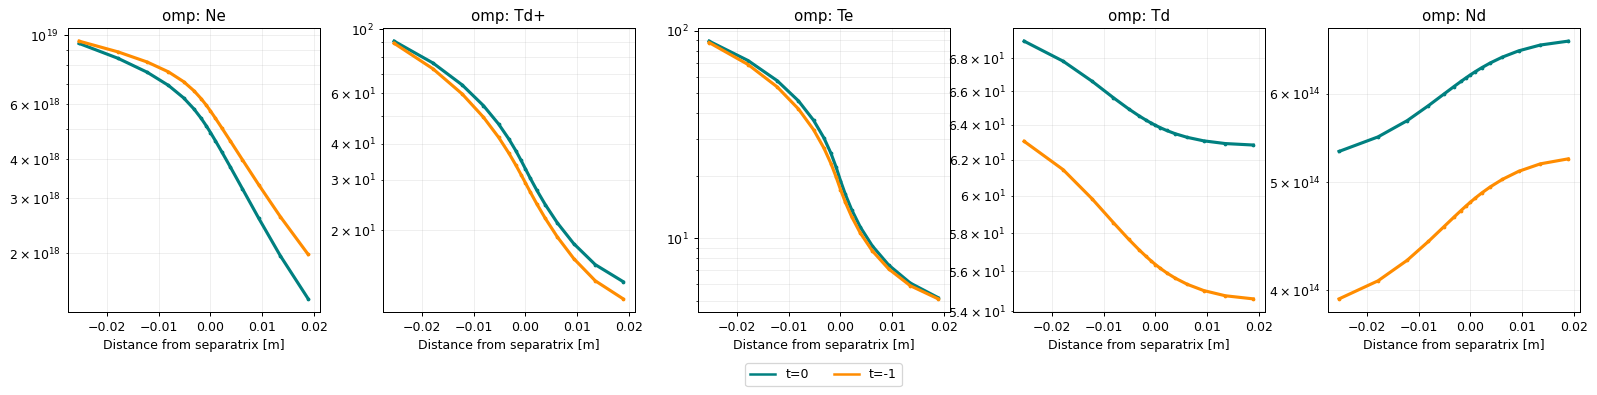

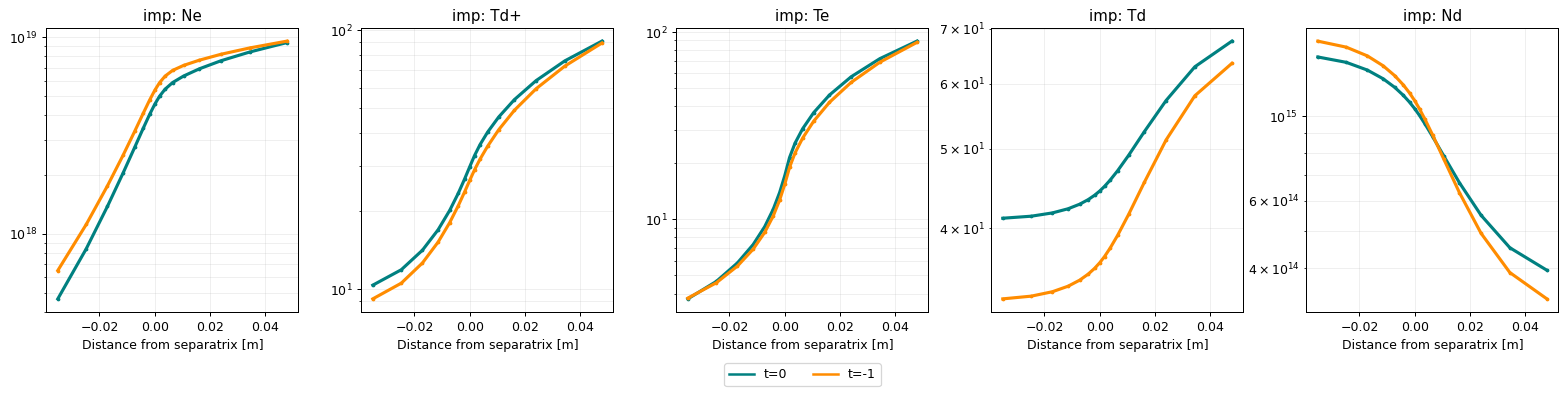

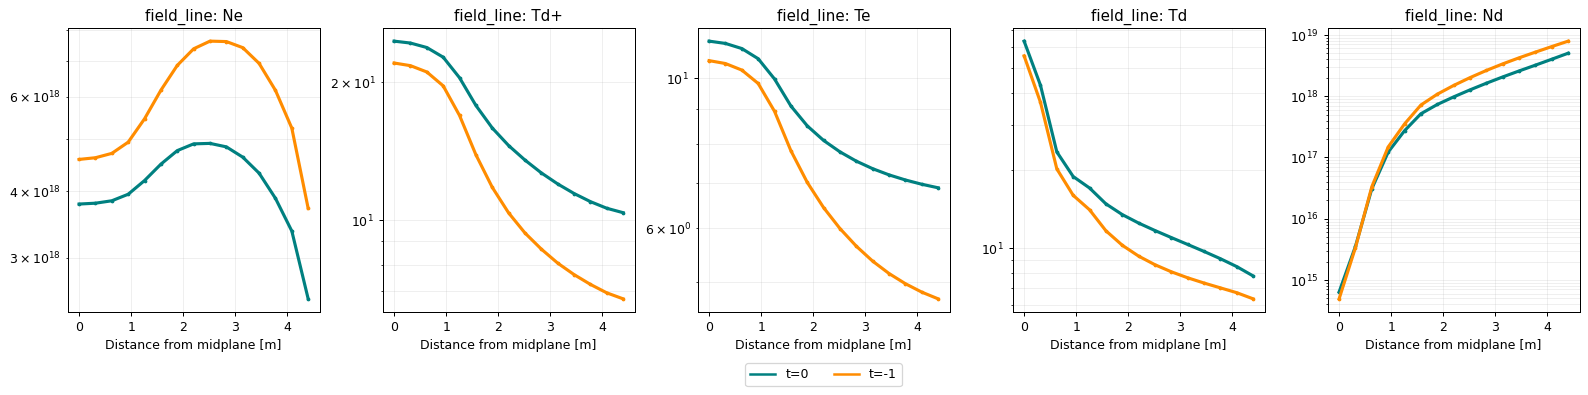

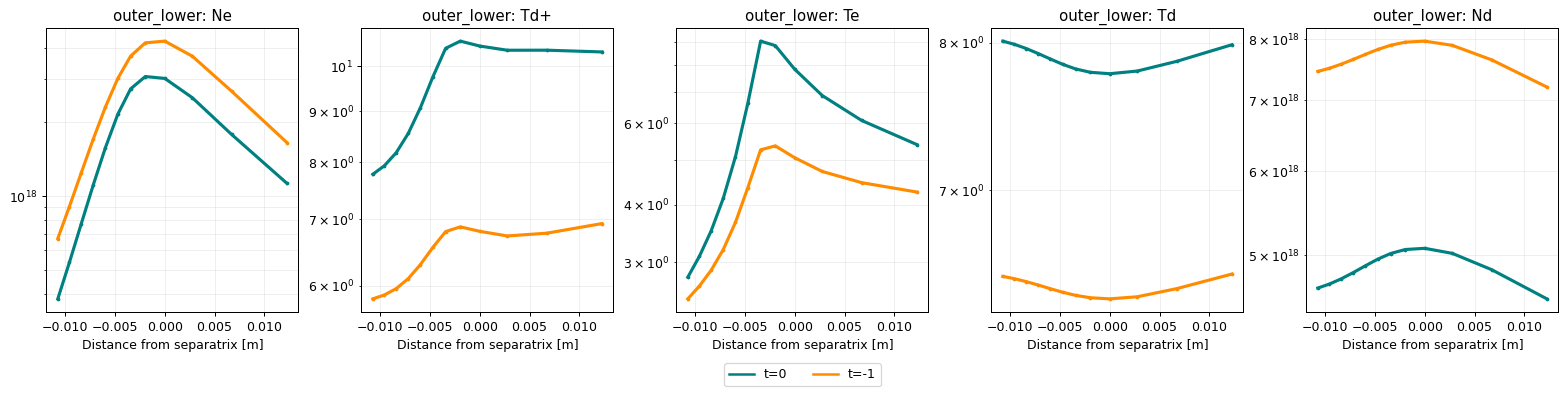

In [5]:
cases = dict()

cases["t=0"] = casestore["base"].ds.isel(t=0, x = slice(2,-2))
cases["t=-1"] = casestore["base"].ds.isel(t=-1, x = slice(2,-2))

lineplot(
    cases = cases,
    clean_guards = False,
    regions = ["omp", "imp", "field_line", "outer_lower"],
    params = ["Ne", "Td+", "Te", "Td", "Nd"],
    # params = ["Pd+", "Pe", "Pd", "NVd+", "NVd"],
    dpi = 90
)

# Source check

In [11]:
casestore["base"].ds.isel(t=-1)["Sd_pump_recycle"].sum("x", "theta")

TypeError: sum() takes from 1 to 2 positional arguments but 3 were given

In [ ]:
[print(x) for x in d.variables.keys()]

In [5]:
"debug" in casestore["base"].ds.data_vars

False

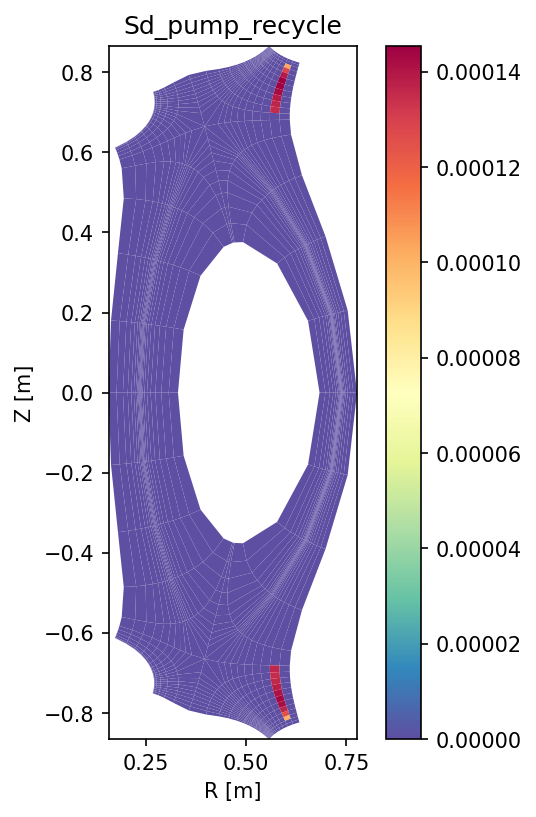

In [6]:
fig, ax = plt.subplots(dpi = 150, figsize = (5,6))
ds = casestore["base"].ds#.isel(t=-1)
fig.subplots_adjust(wspace=0.4)

m = ds.metadata
# hermesm.clean_guards().
(ds["Sd_pump_recycle"]).bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r", vmin = None, vmax = None, logscale = False)
# (ds["Nd+"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r",  logscale = True)

ax.set_aspect("equal")
# ax.set_ylim(-0.87, 0)

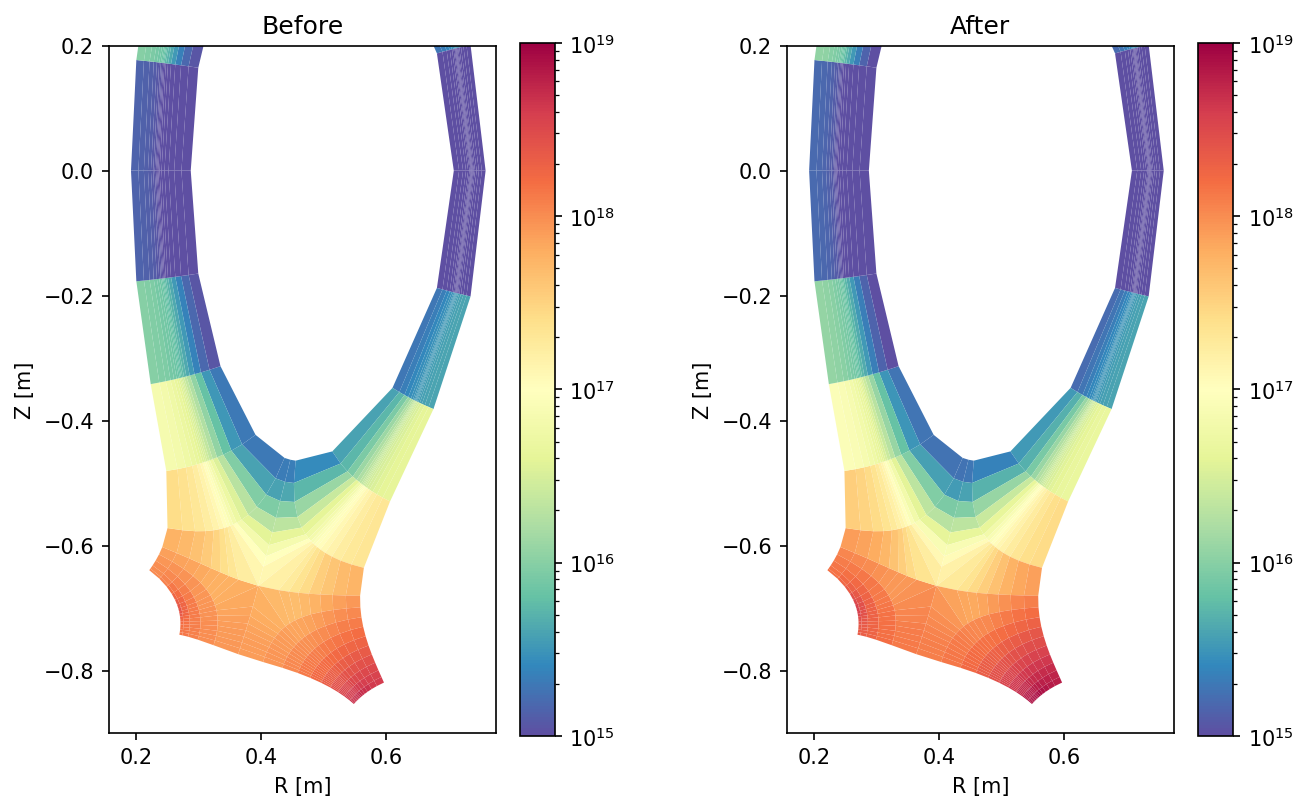

In [6]:
fig, axes = plt.subplots( 1, 2, dpi = 150, figsize = (10,6))

fig.subplots_adjust(wspace=0.4)

max = 1e19
min = 1e15
ax = axes[0]
ds = casestore["base"].ds.isel(t=0)
(ds["Nd"]).hermesm.clean_guards().bout.polygon(ax = ax, antialias = True, vmin = min, vmax = max, cmap = "Spectral_r", logscale = True)

ax = axes[1]
ds = casestore["base"].ds.isel(t=-1)
(ds["Nd"]).hermesm.clean_guards().bout.polygon(ax = ax, antialias = True, vmin = min, vmax = max, cmap = "Spectral_r", logscale = True)

ax.set_aspect("equal")

axes[0].set_title("Before")
axes[1].set_title("After")

for ax in axes:
    ax.set_ylim(-0.9, 0.2)

## Find saved variables

In [ ]:
ds = casestore["dev"].ds
ds.data_vars

In [ ]:
fig, ax = plt.subplots(dpi = 150, figsize = (5,6))

fig.subplots_adjust(wspace=0.4)
ds = casestore["dev"].ds#.isel(t=-1)
m = ds.metadata
(ds["Sd_target_recycle"] * (m["Nnorm"] * m["Omega_ci"])).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r", vmax = 1e23, logscale = True)

ax.set_aspect("equal")
ax.set_ylim(-0.9, 0.2)

## Circumferential recycling plots

# Radial profiles for BC check

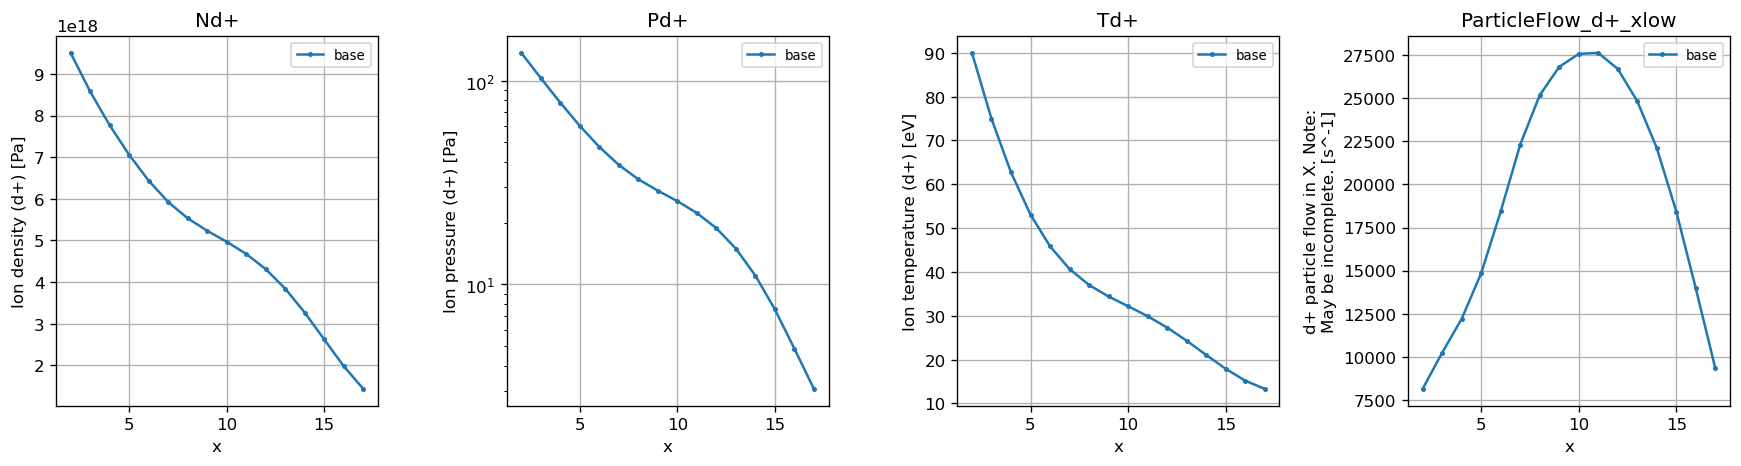

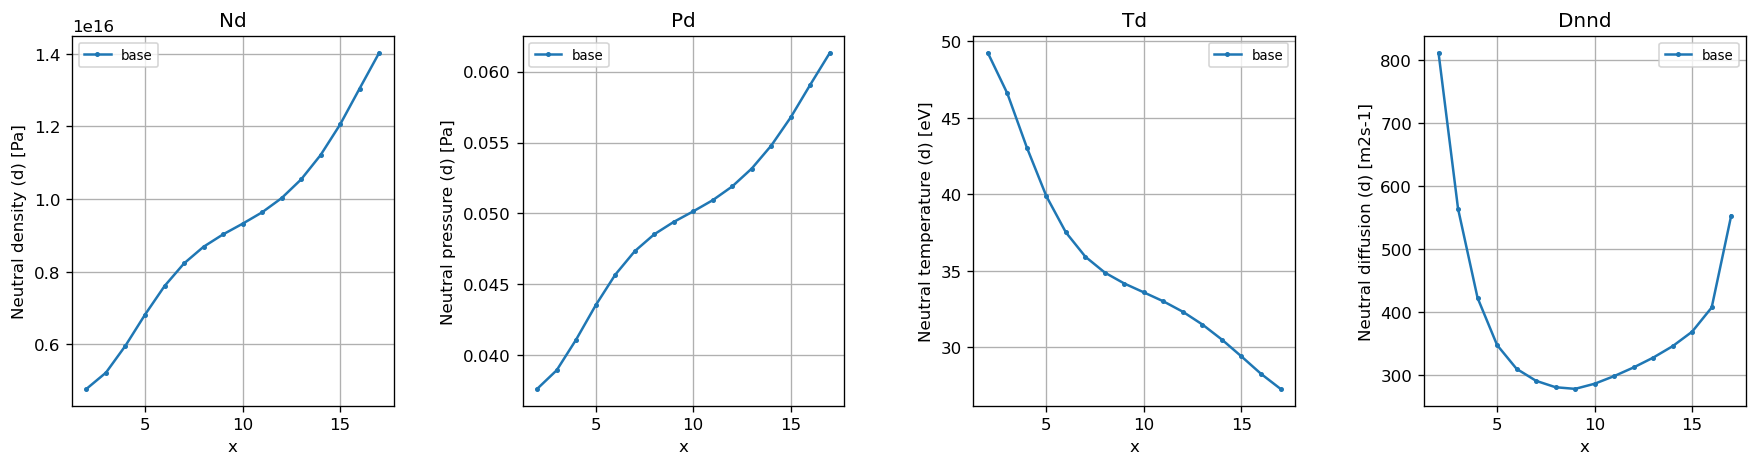

In [6]:
def plot(params):

    fig, axes = plt.subplots(1,len(params), figsize=(4.5*len(params),4), dpi=120)
    fig.subplots_adjust(wspace = 0.4)

    for i, param in enumerate(params):
        for casename in casestore:
            ds = casestore[casename].ds.isel(t=-1, x = slice(2,-2))
            omp = ds.hermesm.select_region("outer_midplane_a")

            (omp[param]).plot(ax = axes[i], marker = "o", label = casename, ms = 2)
            
            if omp[param].max()/omp[param].min() > 10:
                axes[i].set_yscale("log")
        axes[i].grid()
        axes[i].set_title(param)
        axes[i].legend(fontsize = 8)
   

plot(["Nd+", "Pd+", "Td+", "ParticleFlow_d+_xlow"])   
plot(["Nd", "Pd", "Td", "Dnnd"])  
# plot(["Nd", "Pd"])


In [ ]:
toplot = dict()
# case_sel = ["fit_nsep3", "factor"]
case_sel = casestore.keys()
for casename in case_sel:
    toplot[casename] = casestore[casename].ds

lineplot(
    toplot,
    # params = ["Ne", "Td+", "Pd+", "NVd+"],
    params = ["Ne", "Td+", "Nd", "Td"],
    regions = ["field_line", "omp", "outer_lower"],
    # regions = ["omp"],
    scale = "log",
    dpi = 100
)

# Heat and particle balances

### Calculate

In [5]:
for name in casestore:
    casestore[name].ds = calculate_radial_fluxes(casestore[name].ds, force_neumann = False)
    casestore[name].ds = calculate_target_fluxes(casestore[name].ds)
    # casestore[name].ds = calculate_heat_balance(casestore[name].ds)
    # casestore[name].ds = calculate_particle_balance(casestore[name].ds)

In [6]:
casestore["base"].ds.coords

Coordinates:
  * t                        (t) float64 0.3115 0.3116 0.3117 ... 0.3119 0.312
  * x                        (x) int64 0 1 2 3 4 5 6 7 ... 13 14 15 16 17 18 19
  * theta                    (theta) float64 0.1571 0.4712 ... 17.75 18.06
    dx                       (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    dy                       (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    dz                       (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    zShift                   (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    psi_poloidal             (x, theta) float64 -0.02454 -0.02454 ... 0.007641
    R                        (x, theta) float64 0.2671 0.2674 ... 0.6212 0.6235
    Z                        (x, theta) float64 -0.7484 -0.7485 ... -0.8218
    poloidal_distance        (x, theta) float64 -0.001084 -0.0007223 ... 1.696
    poloidal_distance_ylow   (x, theta) float64 -0.001119 -

# New particle balance

In [7]:
ds = casestore["base"].ds

m = ds.metadata
    
core = ds.hermesm.select_region("core_edge")
sol = ds.hermesm.select_region("sol_edge")
pfr = ds.hermesm.select_region("pfr_edge")
domain = ds.hermesm.select_region("all_noguards").squeeze()
domain_volume = domain["dv"].values.sum()
vars = ds.data_vars

df = pd.DataFrame()
pf = dict()

# Radial and edge fluxes
# The summing is clunky but there's apparently no other way in Xarray!
net = dict()
list_places = ["src", "core", "sol", "pfr"]
for place in list_places:
    net[f"pf_int_{place}_net"] = 0

### Calculate all integrals of edge fluxes and sources
for species in m["ion_species"] + m["neutral_species"]:
    ds[f"pf_int_src_{species}"] = (domain[f"S{species}_src"] * domain["dv"]).sum(["x", "theta"]).squeeze()
    ds[f"pf_int_core_{species}"] = core[f"pf_perp_diff_L_{species}"].sum("theta").squeeze()
    ds[f"pf_int_sol_{species}"] = sol[f"pf_perp_diff_R_{species}"].sum("theta").squeeze() * -1 # Positive is going right, which is flowing OUT
    ds[f"pf_int_pfr_{species}"] = pfr[f"pf_perp_diff_L_{species}"].sum("theta").squeeze()

    # Add to net counter for each location
    for place in list_places:
        net[f"pf_int_{place}_net"] += ds[f"pf_int_{place}_{species}"]
    
### Calculate all integrals of recycling sources
for species in m["recycle_pair"].values():
    if f"S{species}_sol_recycle" in vars:
        ds[f"pf_int_recycle_sol_{species}"] = (domain[f"S{species}_sol_recycle"] * domain["dv"]).sum(["x", "theta"]).squeeze() 
    if f"S{species}_pfr_recycle" in vars:
        ds[f"pf_int_recycle_pfr_{species}"] = (domain[f"S{species}_pfr_recycle"] * domain["dv"]).sum(["x", "theta"]).squeeze() 
    if f"S{species}_target_recycle" in vars:
        ds[f"pf_int_recycle_target_{species}"] = (domain[f"S{species}_target_recycle"] * domain["dv"]).sum(["x", "theta"]).squeeze() 
        
    # Add to net counters for each location apart from sources since there are no user set recycling sources
    # Also add to the targets net counter (recycling sources per target basis not done yet)
    for place in list_places + "targets":
        if not any([x in place for x in ["src"]]):
            net[f"pf_int_{place}_net"] += ds[f"pf_int_recycle_{place}_{species}"]
    
### Calculate integrals of target fluxes
# Initialise per-target net counter
for target_name in m["targets"]:
    net[target_name] = 0
net["targets"] = 0

for species in m["ion_species"]:
    net[f"targets_{species}"] = 0
    for target_name in m["targets"]:
        ds[f"pf_int_{target_name}_{species}"] = ds[f"pf_{target_name}_{species}"].sum("x").squeeze()
        net[target_name] += ds[f"pf_int_{target_name}_{species}"]
        net[f"targets_{species}"] += ds[f"pf_int_{target_name}_{species}"]
        
    ds[f"pf_int_targets_{species}"] = net[f"targets_{species}"]
        
for target_name in m["targets"]:
    ds[f"pf_int_{target_name}_net"] = net[target_name]
    net["targets"] += net[target_name]
    
ds[f"pf_int_targets_net"] = net["targets"]


# Atomic reaction fluxes
for ion in m["ion_species"]:
    
    if f"S{ion}_iz" in domain.data_vars:
        neutral = ion.split("+")[0]
        ds[f"pf_int_iz_{ion}"] = (domain[f"S{ion}_iz"] * domain["dv"]).sum(["x", "theta"]).squeeze()
        ds[f"pf_int_iz_{neutral}"] = ds[f"pf_int_iz_{ion}"] * -1
    
    if f"S{ion}_rec" in domain.data_vars:
        ds[f"pf_int_rec_{ion}"] = (domain[f"S{ion}_rec"] * domain["dv"]).sum(["x", "theta"]).squeeze()
        ds[f"pf_int_rec_{neutral}"] = ds[f"pf_int_rec_{ion}"] * -1

# Note: no "net" ionisation or recombination since they net out to zero.

ds[f"pf_int_total_net"] = \
    ds["pf_int_src_net"] + ds["pf_int_core_net"] + ds["pf_int_sol_net"] + ds["pf_int_pfr_net"] \
        + ds["pf_int_targets_net"]

In [8]:
casestore["base"].ds.dims

Frozen({'t': 6, 'x': 20, 'theta': 58})

In [10]:
df = pd.DataFrame()
df.index = ["source", "core", "sol", "sol recycle", "pfr", "pfr recycle", "targets", "targets recycle", "iz", "rec"]
m = ds.metadata

if f"pf_int_{m['targets'][0]}" in ds.data_vars:
    merge_targets = False
else:
    merge_targets = True

last = ds.isel(t=-1)
for species in m["ion_species"] + m["neutral_species"]:
    df.loc["source", species] = last[f"pf_int_src_{species}"]
    df.loc["core", species] = last[f"pf_int_core_{species}"]
    df.loc["sol", species] = last[f"pf_int_sol_{species}"]
    df.loc["pfr", species] = last[f"pf_int_pfr_{species}"]
    
for species in m["ion_species"]:
    if merge_targets is True:
        df.loc["targets", species] = last[f"pf_int_targets_{species}"]
    else:
        for target in m["targets"]:
            df.loc[target, species] = last[f"pf_int_{target}_{species}"]
    
for species in m["ion_species"] + m["neutral_species"]:
    if f"pf_int_iz_{species}" in last.keys():
        df.loc["iz", species] = last[f"pf_int_iz_{species}"]
    if f"pf_int_rec_{species}" in last.keys():
        df.loc["rec", species] = last[f"pf_int_rec_{species}"]
        
for species in m["recycle_pair"].values():
    if f"pf_int_recycle_sol_{species}" in vars:
        df.loc["sol recycle", species] = last[f"pf_int_recycle_sol_{species}"]
    if f"pf_int_recycle_pfr_{species}" in vars:
        df.loc["pfr recycle", species] = last[f"pf_int_recycle_pfr_{species}"]
    if f"pf_int_recycle_target_{species}" in vars:
        df.loc["targets recycle", species] = last[f"pf_int_recycle_target_{species}"]
    
df["total"] = df.sum(axis=1)
imbalance = df["total"].sum()
imbalance_frac = imbalance / (df["total"]["source"] + df["total"]["core"])

# print(f"Recycling fraction: {frec:.2%}")
print(f"Domain volume: {ds['dv'].sum():.3e} [m3]")
print(f"Particle imbalance: {imbalance:,.3e} [s-1]")
print(f"Particle imbalance as frac of core + source: {imbalance_frac:.2%}")
print("---------------------------------------")
print(f"Total fluxes in [s-1]:")

def styler(s):
        if abs(s) < 0.01 or pd.isna(s):
            c =  "color: lightgrey"
        else:
            c =  "color: black"

        return c
        
ts = df.copy().style.format("{:.2e}")
ts = ts.applymap(styler)
display(ts)

Domain volume: 1.607e+00 [m3]
Particle imbalance: -1.344e+19 [s-1]
Particle imbalance as frac of core + source: -2.58%
---------------------------------------
Total fluxes in [s-1]:


,d+,d,total
source,0.00e+00,0.00e+00,0.00e+00
core,5.20e+20,0.00e+00,5.20e+20
sol,-2.80e+20,-0.00e+00,-2.80e+20
sol recycle,nan,nan,0.00e+00
pfr,0.00e+00,0.00e+00,0.00e+00
pfr recycle,nan,nan,0.00e+00
targets,-5.00e+21,nan,-5.00e+21
targets recycle,nan,4.75e+21,4.75e+21
iz,4.75e+21,-4.75e+21,0.00e+00
rec,-6.34e+17,6.34e+17,0.00e+00


In [18]:
(domain["Sd_pfr_recycle"] * domain["dv"]).sum().values

array(0.)

In [ ]:
"""
Plot net domain particle flows and the particle imbalance as a function of time.
Particle flows are aggregated for all heavy species. 
Requires you to have calculated the balance to begin with (see fluxes.py)
"""
fig, ax = plt.subplots(figsize=(4,3), dpi = 150)
m = ds.metadata
data_pos = [ds["pf_int_core_net"], ds["pf_int_sol_net"], ds["pf_int_src_net"]]
labels_pos = ["Core", "SOL", "Source"]

data_neg = [ds["pf_int_targets_net"]]
labels_neg = ["Targets"]

# Ignore first X time for ylim calculation
mins = []
maxs = []
for data in data_neg + data_pos:
    tlen = len(data.coords["t"])
    data = data.isel(t = slice(int(tlen*0.1), None))
    mins.append(np.nanmin(data.values))
    maxs.append(np.nanmax(data.values))
    
max_magnitude = max( [abs(min(mins)), abs(max(maxs))] )
ymin = - max_magnitude * 1.2
ymax = max_magnitude * 1.2

ax.stackplot(ds.coords["t"], data_pos, labels = labels_pos, baseline = "zero", colors = ["teal", "cyan", "navy"], alpha = 0.7)
ax.stackplot(ds.coords["t"], data_neg, labels = labels_neg, baseline = "zero", colors = ["darkorange"], alpha = 0.7)

ax.plot(ds.coords["t"], ds["pf_int_total_net"], lw = 2, ls = "--", c = "k", label = "Imbalance")
ax.set_xlabel("Time [s]")
ax.set_ylabel("Particle flow [s-1]")
ax.set_title("Particle balance")

if ylims != (None, None):
    ax.set_ylim(ylims)
else:
    ax.set_ylim(ymin,ymax)
fig.legend(bbox_to_anchor = (1.25,0.9), loc = "upper right")
ax.grid(lw = 0.5)

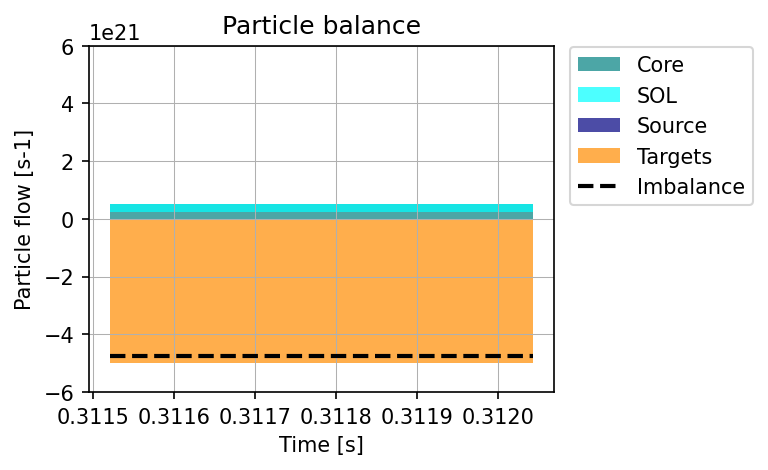

In [11]:
plot_particle_balance(ds)

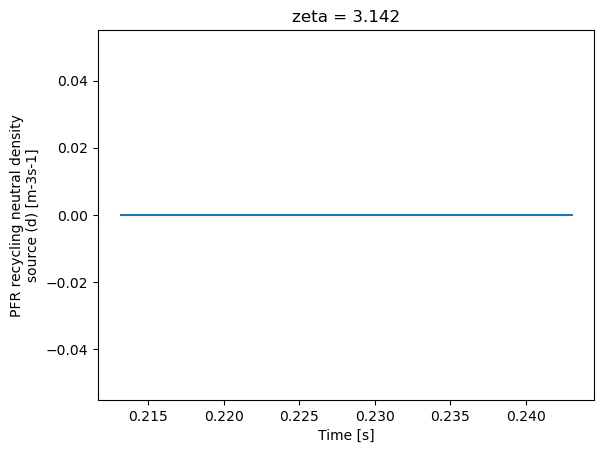

In [16]:
ds["pf_int_recycle_pfr_d"].plot()

In [ ]:
ds.data_vars

In [6]:
for name in ["base"]:
    print(name)
    ds = casestore[name].ds
    show_particle_balance_table(ds)
    # show_heat_balance_table(ds)


base
---------------------------------------
PARTICLE BALANCE
---------------------------------------


Domain volume: 1.607e+00 [m3]
Particle imbalance: -3.978e+20 [s-1]
Particle imbalance as frac of core + source: -147.12%
---------------------------------------
Total fluxes in [s-1]:


,d+,d,total
source,0.00e+00,0.00e+00,0.00e+00
core,2.70e+20,0.00e+00,2.70e+20
sol,-3.78e+20,-0.00e+00,-3.78e+20
pfr,0.00e+00,0.00e+00,0.00e+00
targets,-5.81e+21,5.52e+21,-2.91e+20
iz,5.90e+21,-5.90e+21,0.00e+00
rec,-1.08e+18,1.08e+18,0.00e+00


In [12]:
list(ds.metadata["recycle_pair"].values())

['d']

# Manual flux calcs - validation

In [11]:
ds = casestore["base"].ds.isel(t=-1)
m = ds.metadata

core = ds.hermesm.select_region("core_edge")
sol = ds.hermesm.select_region("sol_edge")
sol_guards = ds.hermesm.select_region("sol_edge_inner_guards")

domain = ds.hermesm.select_region("all_noguards").squeeze()
domain_noy = ds.hermesm.select_region("all_no_y_guards").squeeze()
domain_volume = domain["dv"].values.sum()

Pnorm = m["Nnorm"] * m["Tnorm"] * constants("q_e")
nfluxnorm =  (m["rho_s0"] * m["rho_s0"]**2 * m["Nnorm"] * m["Omega_ci"])
efluxnorm =  (m["rho_s0"] * m["rho_s0"]**2 * Pnorm * m["Omega_ci"])   # W
# nsourcenorm = (m["Nnorm"] * m["Omega_ci"])
# esourcenorm = (Pnorm * m["Omega_ci"]) 

# Let's test normalisations in  Load
nsourcenorm = 1
esourcenorm = 1

# Check SOL recycling fluxes

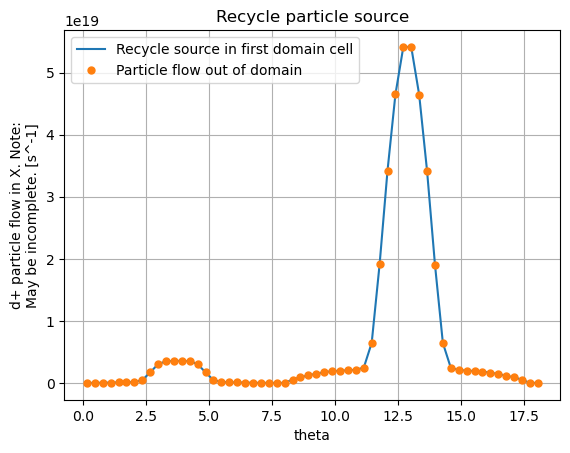

In [12]:
(ds["Sd_sol_recycle"].isel(x=-3) * nsourcenorm * ds["dv"].isel(x=-3)).plot(label = "Recycle source in first domain cell")
(ds["ParticleFlow_d+_xlow"].isel(x=-2) * nfluxnorm).plot(label = "Particle flow out of domain", lw = 0, marker = "o", ms = 5)
plt.legend()
plt.title("Recycle particle source")
plt.grid()
# ds["Sd_target_recycle"].isel(x=-3).plot()

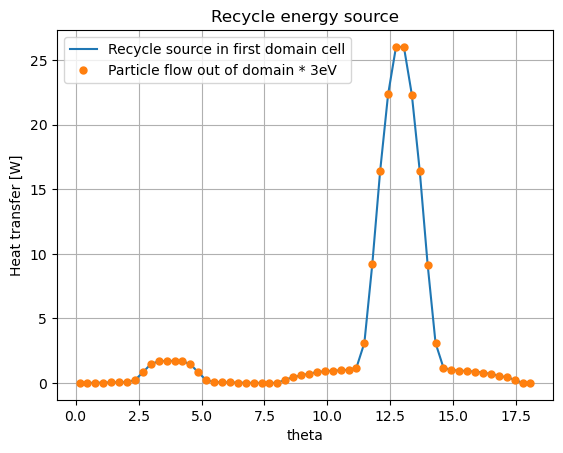

In [13]:
(ds["Ed_sol_recycle"].isel(x=-3) * esourcenorm * ds["dv"].isel(x=-3)).plot(label = "Recycle source in first domain cell")
(ds["ParticleFlow_d+_xlow"].isel(x=-2) * nfluxnorm * 3 * constants("q_e")).plot(label = "Particle flow out of domain * 3eV", lw = 0, marker = "o", ms = 5)
plt.legend()
plt.title("Recycle energy source")
plt.ylabel("Heat transfer [W]")
plt.grid()
# ds["Sd_target_recycle"].isel(x=-3).plot()

# Check target recycling fluxes

In [14]:
ds = calculate_target_fluxes(ds)

### Particles

Total target ion particle flux: 1.627e+95
Total target recycle source: 5.511e+59


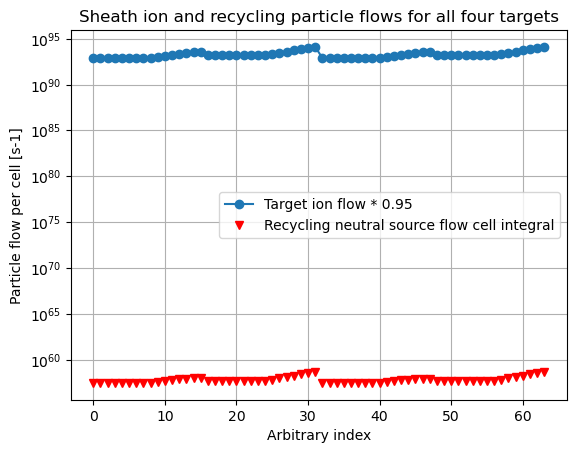

In [15]:
fig, ax = plt.subplots()
frecycle = 0.95

fluxes = []
recycle = []
for name in m["targets"]:
    target = ds.hermesm.select_region(f"{name}_target")
    recycle.append(target["Sd_target_recycle"].values * target["dv"].values * nsourcenorm)
    fluxes.append(ds[f"pf_{name}_d+"].isel(x=slice(2,-2)).values * -1 * frecycle)
fluxes = np.concatenate(fluxes)
recycle = np.concatenate(recycle)
ax.plot(fluxes, marker = "o", label = "Target ion flow * 0.95")
ax.plot(recycle, marker = "v", lw = 0, color = "r", label = "Recycling neutral source flow cell integral")
ax.legend()
ax.set_yscale("log")

tflux_ions = np.sum(fluxes)
tflux_recycle = np.sum(recycle)
print(f"Total target ion particle flux: {tflux_ions:.3e}")
print(f"Total target recycle source: {tflux_recycle:.3e}")
ax.set_xlabel("Arbitrary index")
ax.set_ylabel("Particle flow per cell [s-1]")
ax.set_title("Sheath ion and recycling particle flows for all four targets")
ax.grid()
# target["x"].values

### Energy

KeyError: 'pf_inner_lower_d+'

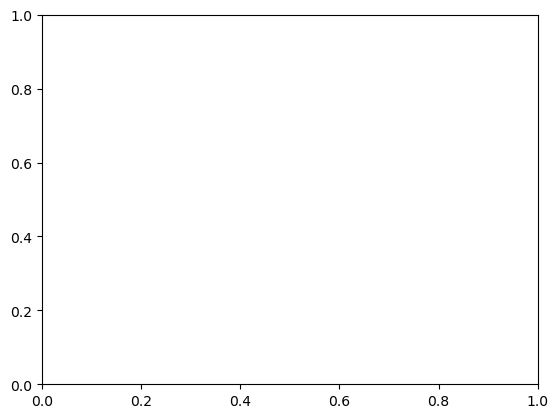

In [8]:
fig, ax = plt.subplots()

fluxes = []
recycle = []
for name in m["targets"]:
    target = ds.hermesm.select_region(f"{name}_target")
    recycle.append(target["Ed_target_recycle"].values * esourcenorm * target["dv"].values)
    fluxes.append(ds[f"pf_{name}_d+"].isel(x=slice(2,-2)).values * -1  * 3 * constants("q_e") * frecycle)
    
fluxes = np.concatenate(fluxes)
recycle = np.concatenate(recycle)
ax.plot(fluxes, marker = "o", label = "Target ion flow * 3eV")
ax.plot(recycle, marker = "v", lw = 0, color = "r", label = "Recycling neutral energy source cell integral")
ax.legend()
ax.set_yscale("log")

tflux_ions = np.sum(fluxes)
tflux_recycle = np.sum(recycle)
print(f"Total target ion particle flux: {tflux_ions:.3e}")
print(f"Total target recycle source: {tflux_recycle:.3e}")
ax.set_xlabel("Arbitrary index")
ax.set_ylabel("Particle flow per cell [s-1]")
ax.set_title("Sheath ion and recycling energy flows for all four targets")
ax.grid()
# target["x"].values

# Check PFR recycling fluxes

Total PFR ion particle flux: -2.778e+19
Total PFR recycle source: 8.495e+59


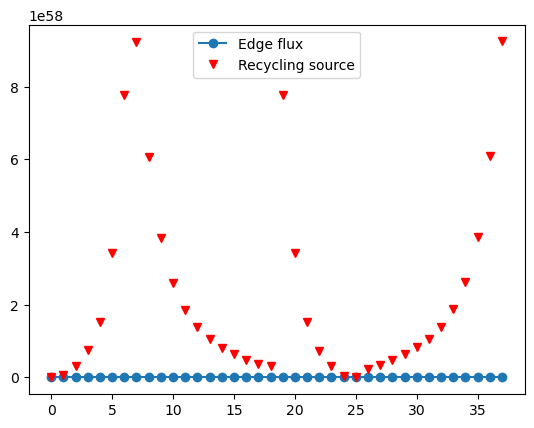

In [7]:
fluxes = []
sources = []
tflux_ions = 0
tflux_recycle = 0

for name in ["lower_pfr_edge", "upper_pfr_edge"]:
    pfr_edge = ds.hermesm.select_region(name)
    fluxes.append((pfr_edge["ParticleFlow_d+_xlow"] * nfluxnorm * -1).squeeze().values)
    sources.append((pfr_edge["Sd_pfr_recycle"] * nsourcenorm * ds["dv"]).squeeze().values)
    
    tflux_ions += (pfr_edge["ParticleFlow_d+_xlow"] * nfluxnorm).values.sum()
    tflux_recycle += (pfr_edge["Sd_pfr_recycle"] * nsourcenorm * pfr_edge["dv"]).values.sum()
    
print(f"Total PFR ion particle flux: {tflux_ions:.3e}")
print(f"Total PFR recycle source: {tflux_recycle:.3e}")
fluxes = np.concatenate(fluxes)
sources = np.concatenate(sources)

fig, ax = plt.subplots()
ax.plot(fluxes, marker = "o", label = "Edge flux")
ax.plot(sources, lw = 0, marker = "v", label = "Recycling source", c = "r")
ax.legend()
# (ds["ParticleFlow_d+_xlow"].isel(x=2) * nfluxnorm * -1).plot(label = "L flow in inner guard cell into domain", lw = 0, marker = "o", ms = 5)
# plt.legend()
# plt.title("Recycle particle source")
# plt.grid()
# # ds["Sd_target_recycle"].isel(x=-3).plot()

### PFR profile

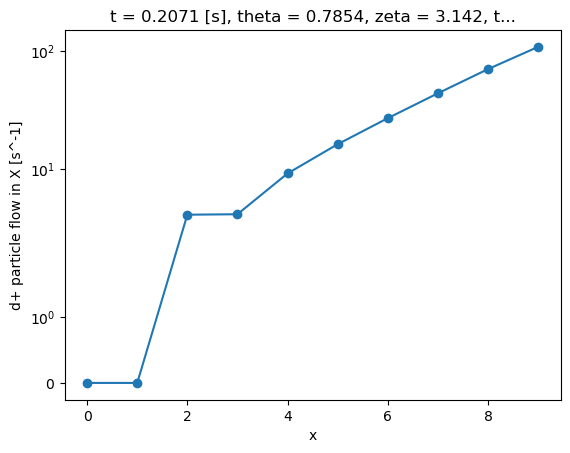

In [ ]:

pfr = ds.hermesm.select_region("lower_pfr")
fig, ax = plt.subplots()
# pfr["Nd+"].isel(theta=2).plot(ax = ax, marker = "o")
pfr["ParticleFlow_d+_xlow"].isel(theta=2).plot(ax = ax, marker = "o")
ax.set_yscale("symlog")

### 2D plot

(-0.87, 0.0)

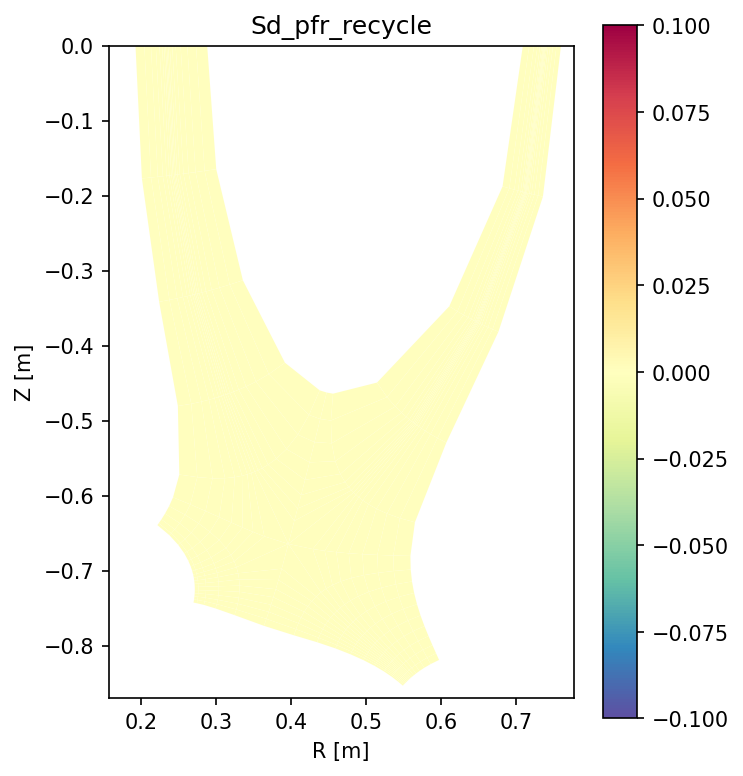

In [21]:
fig, ax = plt.subplots(dpi = 150, figsize = (5,6))

fig.subplots_adjust(wspace=0.4)

m = ds.metadata
# hermesm.clean_guards().
# (ds["ParticleFlow_d+_xlow"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r", vmin = -1e4, vmax = 1e4, logscale = True)
# (ds["Nd+"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r",  logscale = True, vmin = 0.1e18, vmax = 2.5e18)
(ds["Sd_pfr_recycle"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r",  logscale = False, vmin = None, vmax = None)

ax.set_aspect("equal")
ax.set_ylim(-0.87, 0)

In [28]:
pfr_edge["Sd_pfr_recycle"].shape

(1, 19)

In [ ]:
pfr = ds.hermesm.select_region("lower_pfr")

# plot_selection(ds, pfr)

fig, ax = plt.subplots()
pfr["Ne"].plot(ax = ax, log = True)

# SOL edge gradients

Text(0.5, 1.0, '(last - guard)/last (+ve = out of domain)')

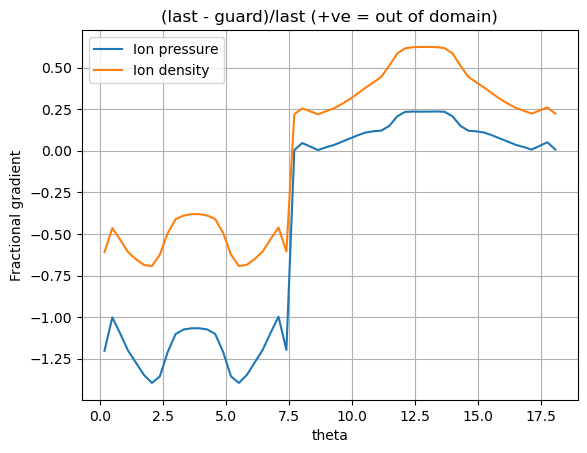

In [19]:
((ds["Pd+"].isel(x=-3) - ds["Pd+"].isel(x=-2)) /  ds["Pd+"].isel(x=-3)).plot(label = "Ion pressure")
((ds["Nd+"].isel(x=-3) - ds["Nd+"].isel(x=-2)) /  ds["Nd+"].isel(x=-3)).plot(label = "Ion density")
# (ds["Pd+"].isel(x=-2) *-1).plot(label = "recycle")
# (ds["ParticleFlow_d+_xlow"].isel(x=-2) * nfluxnorm).plot(label = "flux")
plt.legend()
plt.grid()
plt.ylabel("Fractional gradient")
plt.title("(last - guard)/last (+ve = out of domain)")
# ds["Sd_target_recycle"].isel(x=-3).plot()

In [ ]:
plot_selection(ds, domain_noy)

In [7]:
domain_noy.isel(x=-2)["ParticleFlow_d+_xlow"].values.sum() * nfluxnorm

-7.384019150539778e+19

In [8]:
domain_noy.isel(x=-2)["ParticleFlow_d+_xlow"].values.sum() * nfluxnorm * (3 * constants("q_e"))

-35.49150853388127

In [10]:
species = "d+"
core_flux = core[f"pf_perp_diff_L_{species}"].sum("theta").squeeze().values
sol_flux = sol_guards[f"pf_perp_diff_L_{species}"].sum("theta").squeeze().values * -1
pfr_flux = pfr[f"pf_perp_diff_L_{species}"].sum("theta").squeeze().values
target_flux = ds["pf_int_targets_d+"].values
recycle_flux = (domain["Sd_target_recycle"]* (m["Nnorm"] * m["Omega_ci"]) * domain["dv"]).sum().values 

print(f"Core flux: {core_flux:.2e}")
print(f"SOL flux: {sol_flux:.2e}")
print(f"PFR flux: {pfr_flux:.2e}")
print(f"Target flux: {target_flux:.2e}")
print(f"Recycle flux: {recycle_flux:.2e}")

Core flux: 2.25e+20
SOL flux: -7.38e+19
PFR flux: 0.00e+00
Target flux: -3.05e+21
Recycle flux: 2.73e+21


In [46]:
ds["pf_int_targets_d+"].values[0]

-3.050598318477588e+21

In [39]:
frecycle = 0.95
total = 0
for loc in ["inner_lower_target", "inner_upper_target", "outer_upper_target", "outer_lower_target"]:
    target = ds.hermesm.select_region(loc)
    recycle_source = (target["Sd_src_recycle"] * (m["Nnorm"] * m["Omega_ci"] * target["dv"])).sum().values 
    total += recycle_source 
    print(f"{loc}: {recycle_source:.2e}")
    

print(f"Recycle flux: {total:.2e}")

inner_lower_target: 3.57e+20
inner_upper_target: 3.58e+20
outer_upper_target: 1.09e+21
outer_lower_target: 1.09e+21
Recycle flux: 2.90e+21


# Post-processing

## 2D plots

In [10]:
%matplotlib inline

In [8]:
ds.data_vars

Data variables:
    Bxy                   (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Dnnd                  (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Ed+_iz                (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Ed+_rec               (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Ed_pfr_recycle        (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Ed_pump_recycle       (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Ed_sol_recycle        (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Ed_target_recycle     (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    Edd+_cx               (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    EnergyFlow_d+_xlow    (x, theta) float64 dask.array<chunksize=(20, 7), meta=np.ndarray>
    EnergyFlow_d+_ylow    (x, theta) float64 dask.array<chunksiz

In [6]:
ds["Sd_pump_recycle"].values.sum()

0.0

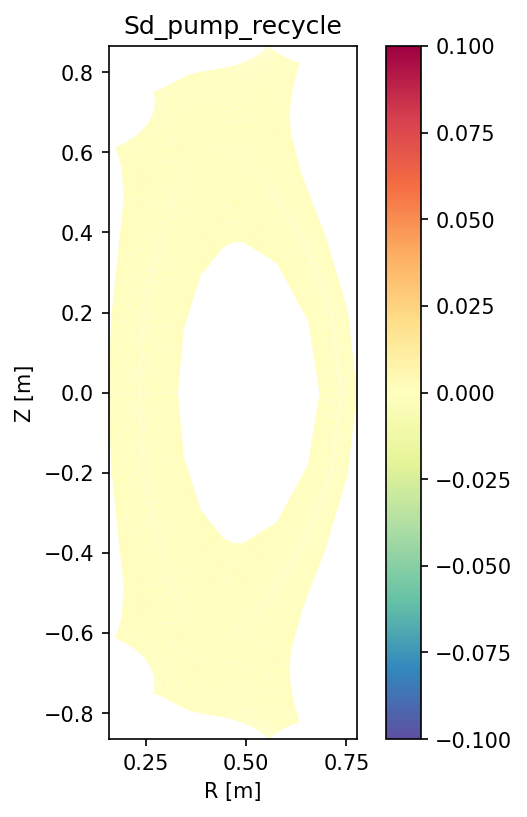

In [5]:
fig, ax = plt.subplots(dpi = 150, figsize = (5,6))
ds = casestore["base"].ds
fig.subplots_adjust(wspace=0.4)

m = ds.metadata
# hermesm.clean_guards().
(ds["Sd_pump_recycle"]).bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r", vmin = None, vmax = None, logscale = False)
# (ds["Nd+"]).hermesm.clean_guards().bout.polygon(ax = ax,antialias = True, cmap = "Spectral_r",  logscale = True)

ax.set_aspect("equal")
# ax.set_ylim(-0.87, 0)

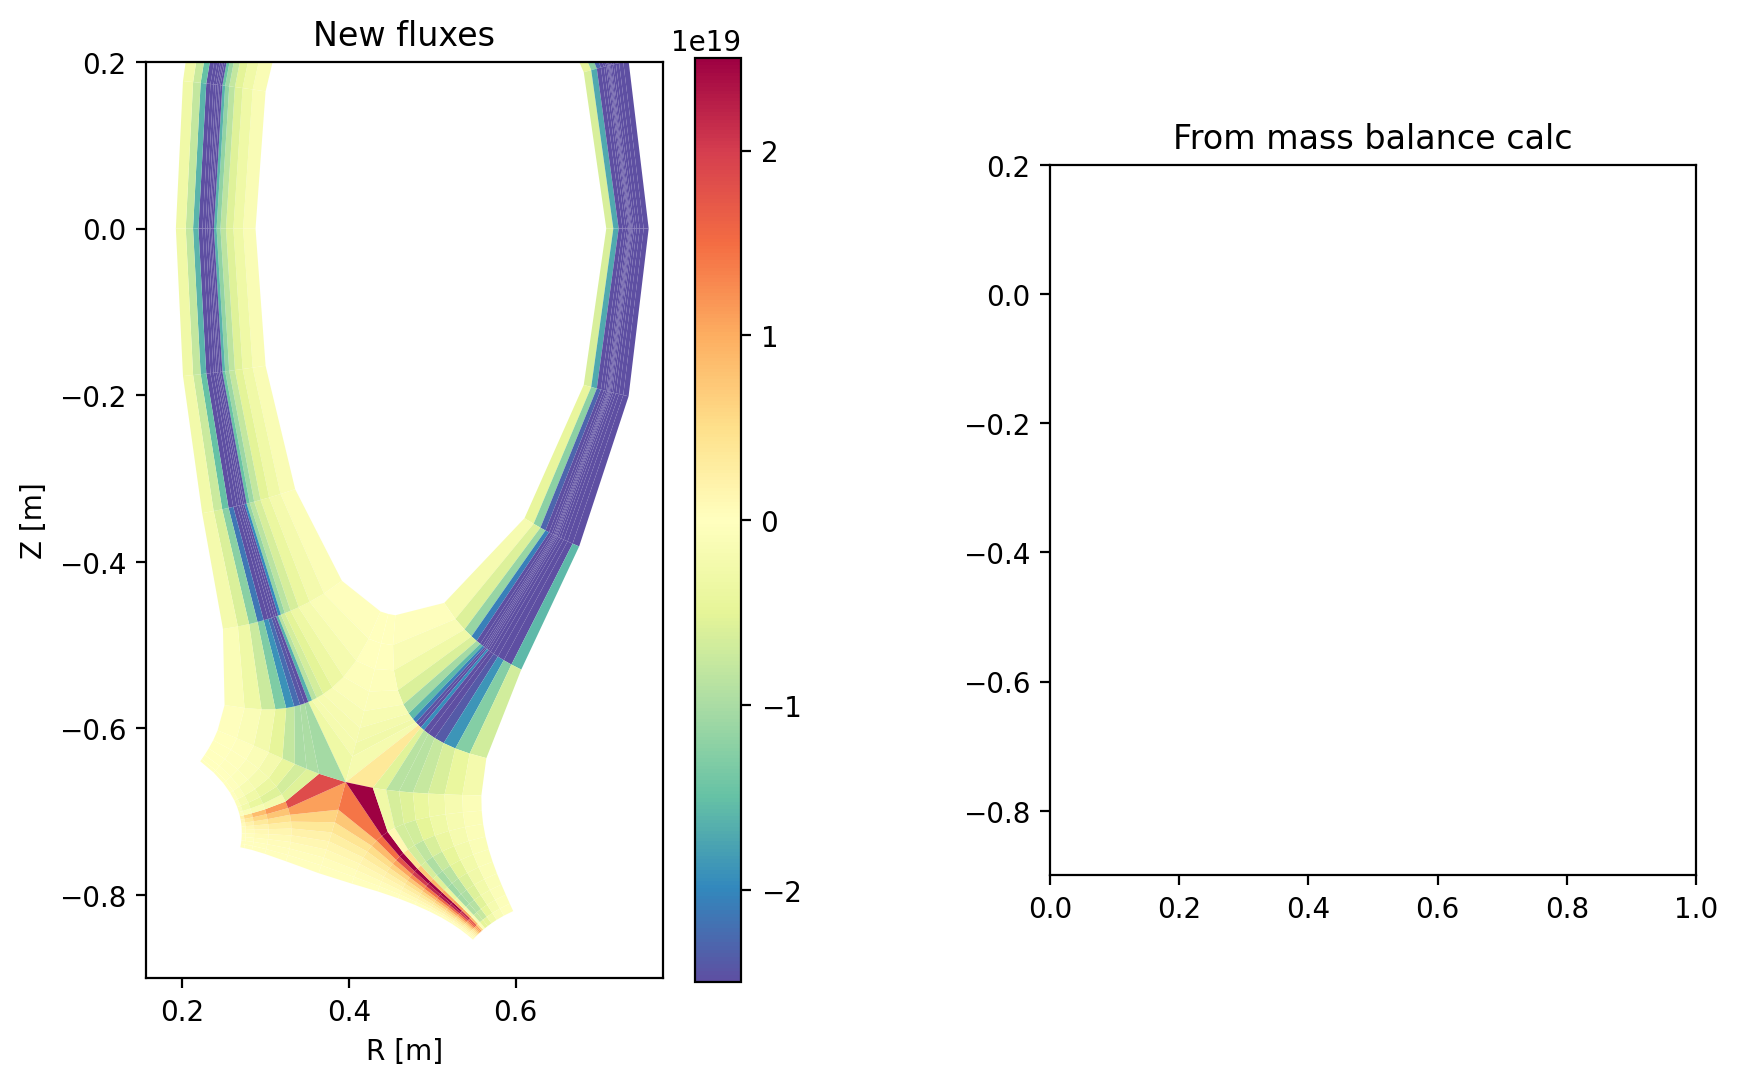

In [16]:
fig, axes = plt.subplots( 1, 2, dpi = 200, figsize = (10,6))

fig.subplots_adjust(wspace=0.4)
ds = casestore["base"].ds.isel(t=-1)
m = ds.metadata
ax = axes[0]
(ds["ParticleFlow_d+_xlow"] * (m["rho_s0"] * m["rho_s0"]**2 * m["Nnorm"] * m["Omega_ci"])).hermesm.clean_guards().bout.polygon(ax = axes[0],antialias = True, vmin = -0.25e20, vmax = 0.25e20, cmap = "Spectral_r")

ax = axes[1]
# (ds["pf_perp_diff_L_d+"]*-1).bout.polygon(ax = axes[1],antialias = True, cmap = "Spectral_r")

ax.set_aspect("equal")

axes[0].set_title("New fluxes")
axes[1].set_title("From mass balance calc")

for ax in axes:
    ax.set_ylim(-0.9, 0.2)

{'xlim': (None, None), 'ylim': (None, None), 'figure_aspect': 0.9, 'wspace_modifier': 1, 'view': 'lower_divertor', 'dpi': 100}


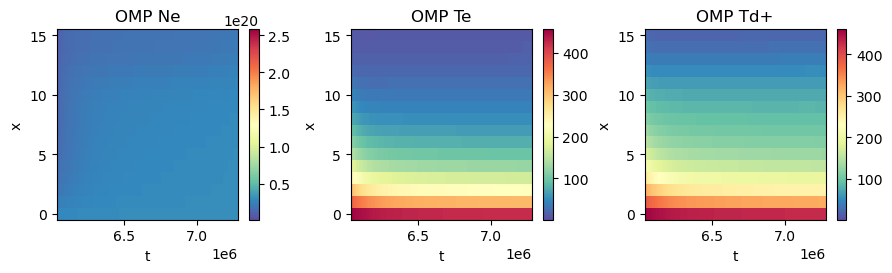

In [5]:
self = Monitor2D(caseng, mode = "omp_history", windows = [["Ne", "Te", "Td+"]], 
                 settings = {
                    "all":{"view":"lower_divertor", "dpi": 100},
                    "Ne":{"vmax":None},
                    "Te":{"vmin":None, "vmax":None},
                    "Td+":{"vmin":None, "vmax":None},
                    })

{'xlim': (None, None), 'ylim': (None, None), 'figure_aspect': 0.9, 'wspace_modifier': 1, 'view': 'None', 'dpi': 150}


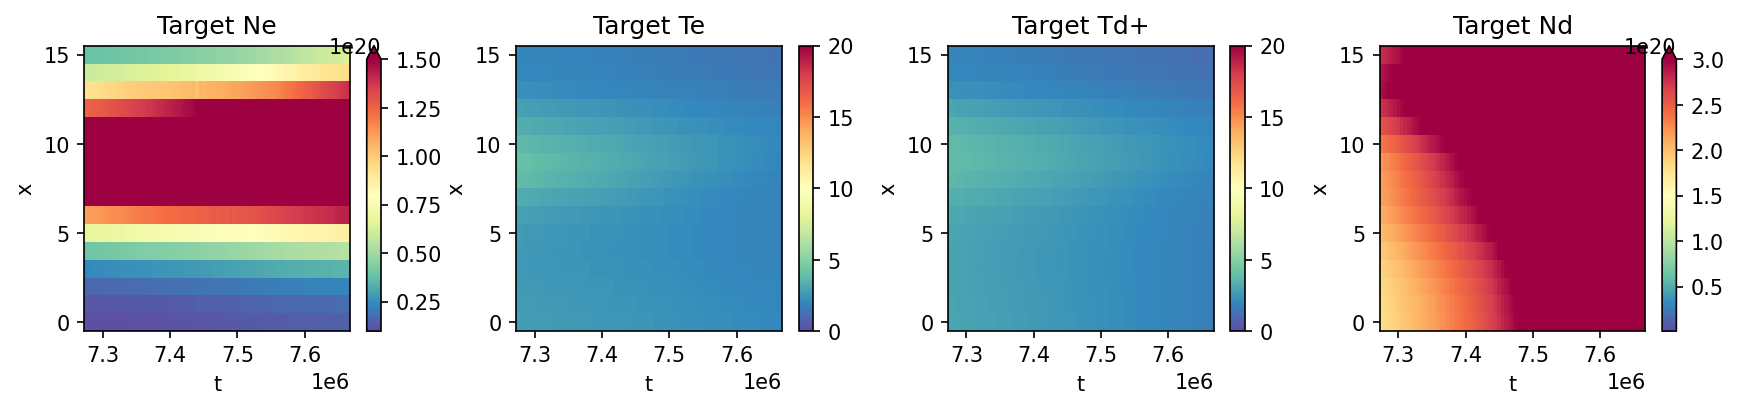

In [5]:
self = Monitor2D(caseng, mode = "target_history", windows = [["Ne", "Te", "Td+", "Nd"]], 
                 settings = {
                    "all":{"view":"None", "dpi": 150},
                    "Ne":{"vmax":15e19},
                    "Te":{"vmin":0, "vmax":20},
                    "Td+":{"vmin":0, "vmax":20},
                    "Nd":{"vmin":1e18, "vmax":3e20}
                    })

{'xlim': (None, None), 'ylim': (None, None), 'figure_aspect': 0.9, 'wspace_modifier': 1, 'view': None, 'dpi': 100}


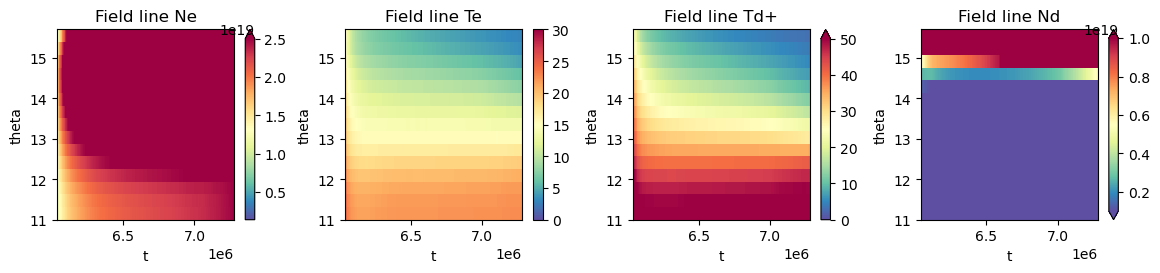

In [7]:
self = Monitor2D(caseng, mode = "field_line_history", windows = [["Ne", "Te", "Td+", "Nd"]], 
                 settings = {
                  #   "all":{"view":"lower_divertor", "dpi": 100},
                    "Ne":{"vmax":2.5e19},
                    "Te":{"vmin":0, "vmax":30},
                    "Td+":{"vmin":0, "vmax":50},
                    "Nd":{"vmin":1e18, "vmax":1e19}
                    })

In [11]:
caseng.unnormalise(unnormalise_geom=False)

--> dx, dy and J will not be unnormalised


{'xlim': (None, None), 'ylim': (None, None), 'figure_aspect': 0.9, 'wspace_modifier': 1, 'view': None, 'dpi': 100}


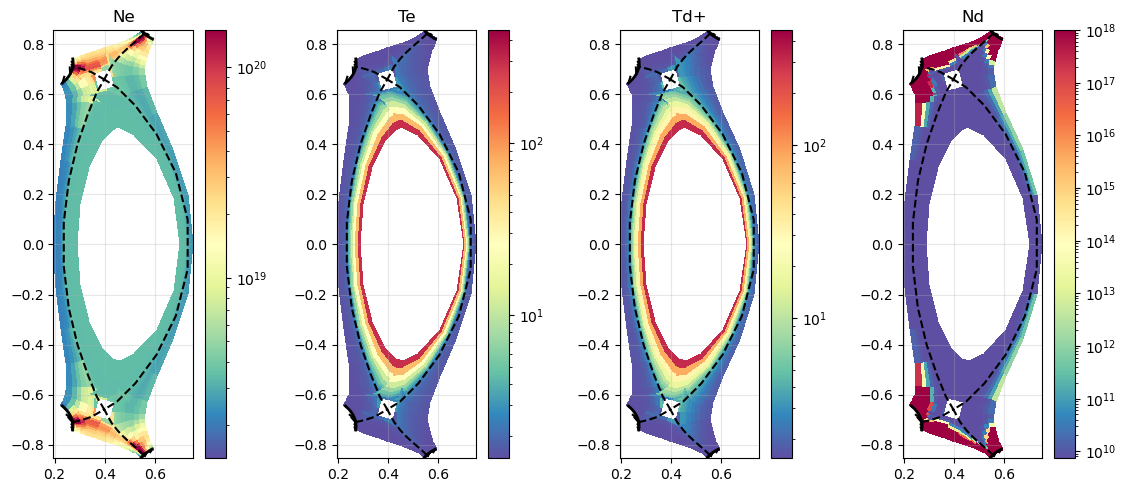

In [16]:
self = Monitor2D(caseng, mode = "pcolor", windows = [["Ne", "Te", "Td+", "Nd"]], 
                 settings = {
                    "all":{"view":None, "dpi": 100},
                    "Sd_src":{"log":False},
                    "Ne":{"vmin":None, "vmax":15e19},
                    "Te":{"log":True, "vmin":None, "vmax":None},
                    "Td+":{"log":True, "vmin":None, "vmax":None},
                    "Nd":{"log":True, "vmin":None, "vmax":1e18}
                    })